In [ ]:
!pip install missingno

  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP
0    adviser     32/60   125   256   6000   256     16    128  198
1     amdahl    470v/7    29  8000  32000    32      8     32  269
2     amdahl   470v/7a    29  8000  32000    32      8     32  220
3     amdahl   470v/7b    29  8000  32000    32      8     32  172
4     amdahl   470v/7c    29  8000  16000    32      8     16  132
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 14.8+ KB
Non

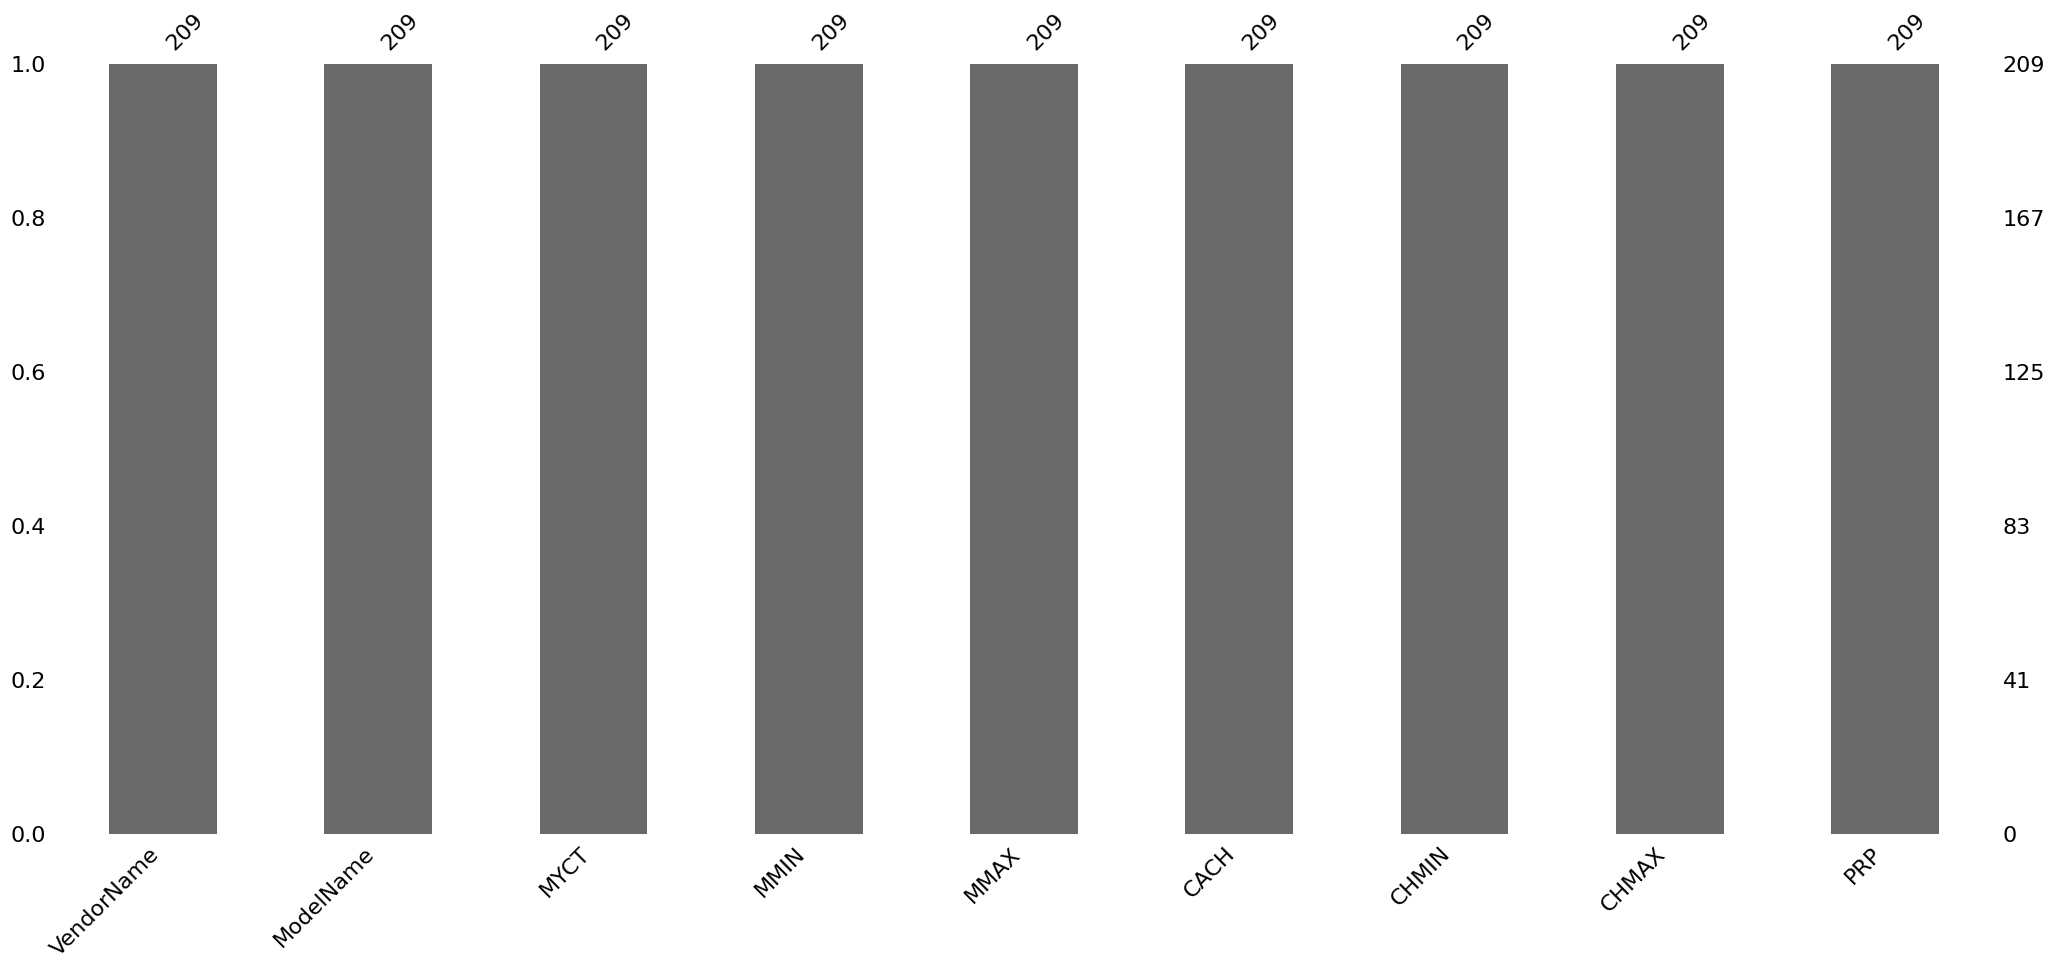

Selected Features: ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
Best Estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MYCT', 'MMIN', 'MMAX',
                                                   'CACH', 'CHMIN',
                                                   'CHMAX'])])),
                ('ensemble',
                 VotingRegressor(estimators=[('lr', LinearRegression()),
                                             ('sgd',
                                              SGDRegressor(alpha=0.01,
                                                           random_state=42)),
                                             ('ridge',
                                              Ridge(alpha=20, random_state=42)),
           

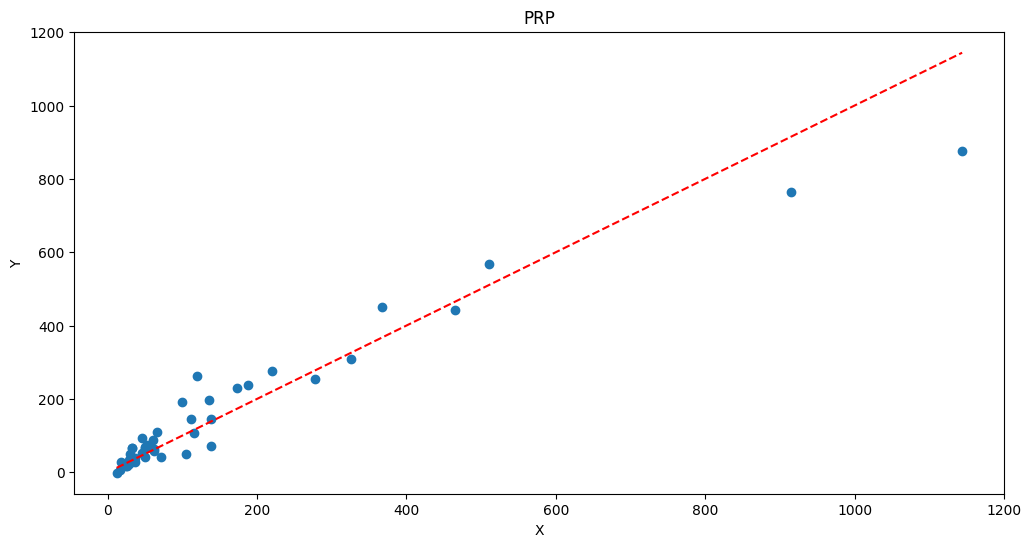

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msn
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

# 데이터 로드
cpu = pd.read_csv("machine_data.csv")

# 데이터 탐색 및 시각화
print(cpu.head())
print(cpu.info())
print(cpu.describe())
msn.bar(cpu)
plt.show()

# 결측치 제거
cpu.dropna(inplace=True)

# 범주형 데이터 수치화
dum = pd.get_dummies(cpu.VendorName, prefix='v', dtype=float)
cpu = pd.concat([cpu.drop('VendorName', axis=1), dum], axis=1)

dum = pd.get_dummies(cpu.ModelName, prefix='m', dtype=float)
cpu = pd.concat([cpu.drop('ModelName', axis=1), dum], axis=1)

#피처 선택
top_features = ['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX']  
print(f"Selected Features: {top_features}")

# 데이터 분리
X = cpu[top_features]  # 특징 변수
y = cpu['PRP']         # 타겟 변수

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# 전처리
num_tranformer = Pipeline(steps=[('scaler',StandardScaler()),])

preprocessor = ColumnTransformer(transformers = [('num',num_tranformer,top_features),])

models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor(random_state=42)),
    ('ridge', Ridge(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]

#앙상블
ensemble = VotingRegressor(estimators=models)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

#하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.001, 0.01],
    'ensemble__sgd__max_iter': [1000, 2000],
    'ensemble__ridge__alpha': [10, 20],
    'ensemble__gbr__n_estimators': [100, 200], 
    'ensemble__gbr__learning_rate': [0.01, 0.1]
}
# GridSearchCV의 best_estimator모델을 사용
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5,scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best Estimator:", grid_search.best_estimator_)
print("Best Parameters:", grid_search.best_params_)

# 테스트 데이터 예측
y_pred = grid_search.best_estimator_.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE: {mse}')
print(f'Test MAE: {mae}')
print(f'Test R^2: {r2}')

# 교차 검증을 통한 성능 평가
cv_mse_scores = -cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mae_scores = -cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_r2_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='r2')

cv_mse = cv_mse_scores.mean()
cv_mae = cv_mae_scores.mean()
cv_r2 = cv_r2_scores.mean()

# 실제 값과 예측 값 시각화
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PRP')
plt.show()

In [3]:
#성능 따로 출력
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE:{mae}, R^2:{r2}")

MSE: 3953.595564027025, MAE:38.970149040741546, R^2:0.9244931072792573


In [4]:
# 결과를 데이터프레임으로 저장
performance_data = {
    'Model': ['Best_estimator', 'Best_estimator', 'Best_estimator'],
    'Data': ['Train', 'Test', 'Cross Validation'],
    'MSE': [mean_squared_error(y_train, grid_search.best_estimator_.predict(X_train)), mse, cv_mse],
    'MAE': [mean_absolute_error(y_train, grid_search.best_estimator_.predict(X_train)), mae, cv_mae],
    'R^2': [r2_score(y_train, grid_search.best_estimator_.predict(X_train)), r2, cv_r2]
}

results_df = pd.DataFrame(performance_data)

# CSV 파일로 저장
results_df.to_csv('pipeline_cpu_data.csv', index=False)

               Model              Data          MSE        MAE       R^2
0  Linear Regression             Train  3345.025454  34.207853  0.816745
1  Linear Regression              Test  4654.851831  45.054513  0.911100
2  Linear Regression  Cross Validation  6622.144368  39.047665  0.624502
3     Best_estimator             Train  1951.272111  25.775327  0.893101
4     Best_estimator              Test  3953.595564  38.970149  0.924493
5     Best_estimator  Cross Validation  5692.435513  33.016503  0.723353


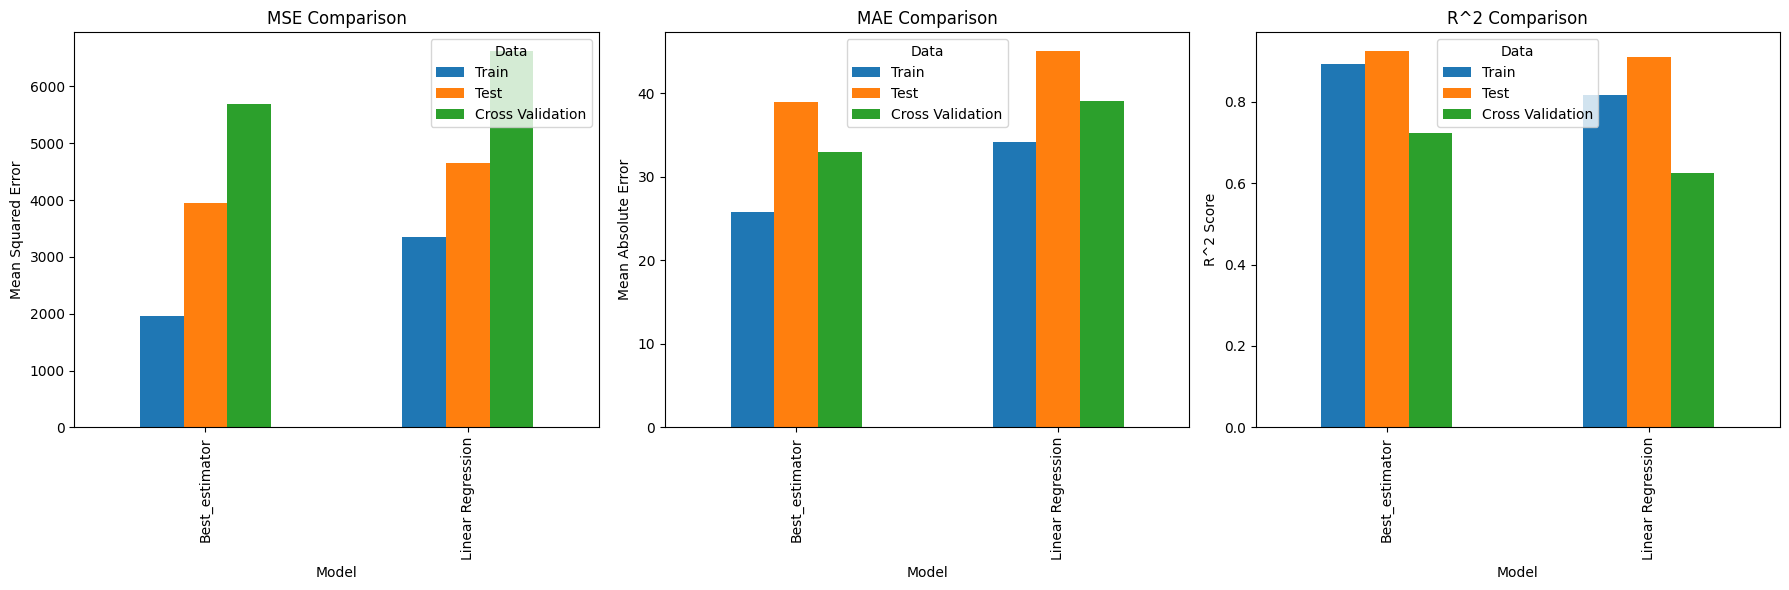

In [5]:
# CSV 파일 읽어오기
linear_results = pd.read_csv('linear_cpu_data.csv')
pipeline_results = pd.read_csv('pipeline_cpu_data.csv')

combined_results = pd.concat([linear_results, pipeline_results], ignore_index=True)

combined_results['Data'] = pd.Categorical(combined_results['Data'], categories=['Train', 'Test', 'Cross Validation'], ordered=True)

print(combined_results)

mse_data = combined_results.pivot(index='Model', columns='Data', values='MSE')
mae_data = combined_results.pivot(index='Model', columns='Data', values='MAE')
r2_data = combined_results.pivot(index='Model', columns='Data', values='R^2')

# 그래프 시각화
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# MSE 
mse_data.plot(kind='bar', ax=axes[0])
axes[0].set_title('MSE Comparison')
axes[0].set_ylabel('Mean Squared Error')

# MAE 
mae_data.plot(kind='bar', ax=axes[1])
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('Mean Absolute Error')

# R^2 
r2_data.plot(kind='bar', ax=axes[2])
axes[2].set_title('R^2 Comparison')
axes[2].set_ylabel('R^2 Score')


plt.tight_layout()
plt.show()
